*This study was conducted for skills demonstration purposes only*

# **Forecasting the UK Construction Sector with Macroeconomic Indicators**
# Section 4. Exploratory Data Analysis (EDA)

In the previous sections, all necessary data was collected, cleaned, formatted, normalized, standardized and saved as df_final.csv, df_normalized_final.csv and df_standardized_final.csv. All outliers were processed. In this section final datasets will be analyzed and investigated for dependencies between indicators with data visualization methods.

### 1. Tools and Libraries

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### 2. Loading data

In [10]:
#Reading data
df = pd.read_csv('df_final.csv')
df_normalized = pd.read_csv('df_normalized_final.csv')
df_standardized = pd.read_csv('df_standardized_final.csv')

In [11]:
df.columns

Index(['Consumer Price Index incl. housing', 'GDP, £m', 'Employment rate, %',
       'BoE Rate, %', 'GBP/EUR', 'GBP/USD', 'Business Investment, % change',
       'Govt Expenditure, £m', 'Construction output, £m',
       'Construction Material Price Index, 2015 = 100',
       'Small construction companies', 'Medium construction companies',
       'Large construction companies', 'Number of all construction companies',
       'Employees - Small construction companies',
       'Employees - Medium construction companies',
       'Employees - Large construction companies',
       'Employees - All construction companies',
       'New Contracts - Public Housing, £m',
       'New Contracts - Private Housing, £m',
       'New Contracts - Infrastructure, £m', 'New contracts - Other, £m',
       'New Contracts - Private Industrial, £m',
       'New Contracts - Private Commercial, £m',
       'New contracts - All Construction, £m'],
      dtype='object')

### 3. Summary Statistics

In [12]:
#df.describe(include='all')

### 4. Correlation Heatmap

For the correlation heatmap the dataset with standartized data 'df_standardized' will be used because it scales all variables to a mean of 0 and standard deviation of 1, ensuring equal contribution regardless of original units (e.g., £m, %, indices). This aligns with Pearson correlation assumptions, providing accurate and comparable linear relationships across diverse columns.

In [13]:
#Check the columns list
df_standardized.columns

Index(['Consumer Price Index incl. housing_standardized',
       'GDP, £m_standardized', 'Employment rate, %_standardized',
       'BoE Rate, %_standardized', 'GBP/EUR_standardized',
       'GBP/USD_standardized', 'Business Investment, % change_standardized',
       'Govt Expenditure, £m_standardized',
       'Construction output, £m_standardized',
       'Construction Material Price Index, 2015 = 100_standardized',
       'Small construction companies_standardized',
       'Medium construction companies_standardized',
       'Large construction companies_standardized',
       'Number of all construction companies_standardized',
       'Employees - Small construction companies_standardized',
       'Employees - Medium construction companies_standardized',
       'Employees - Large construction companies_standardized',
       'Employees - All construction companies_standardized',
       'New Contracts - Public Housing, £m_standardized',
       'New Contracts - Private Housing, £m_standa

Due to the long list of columns, the heat map will be split into two parts for better visibility: 'Strong Correlations (|r| > 0.5): Macroeconomic vs Construction Indicators' and 'Weak Correlations (|r| <= 0.5): Macroeconomic vs Construction Indicators'.

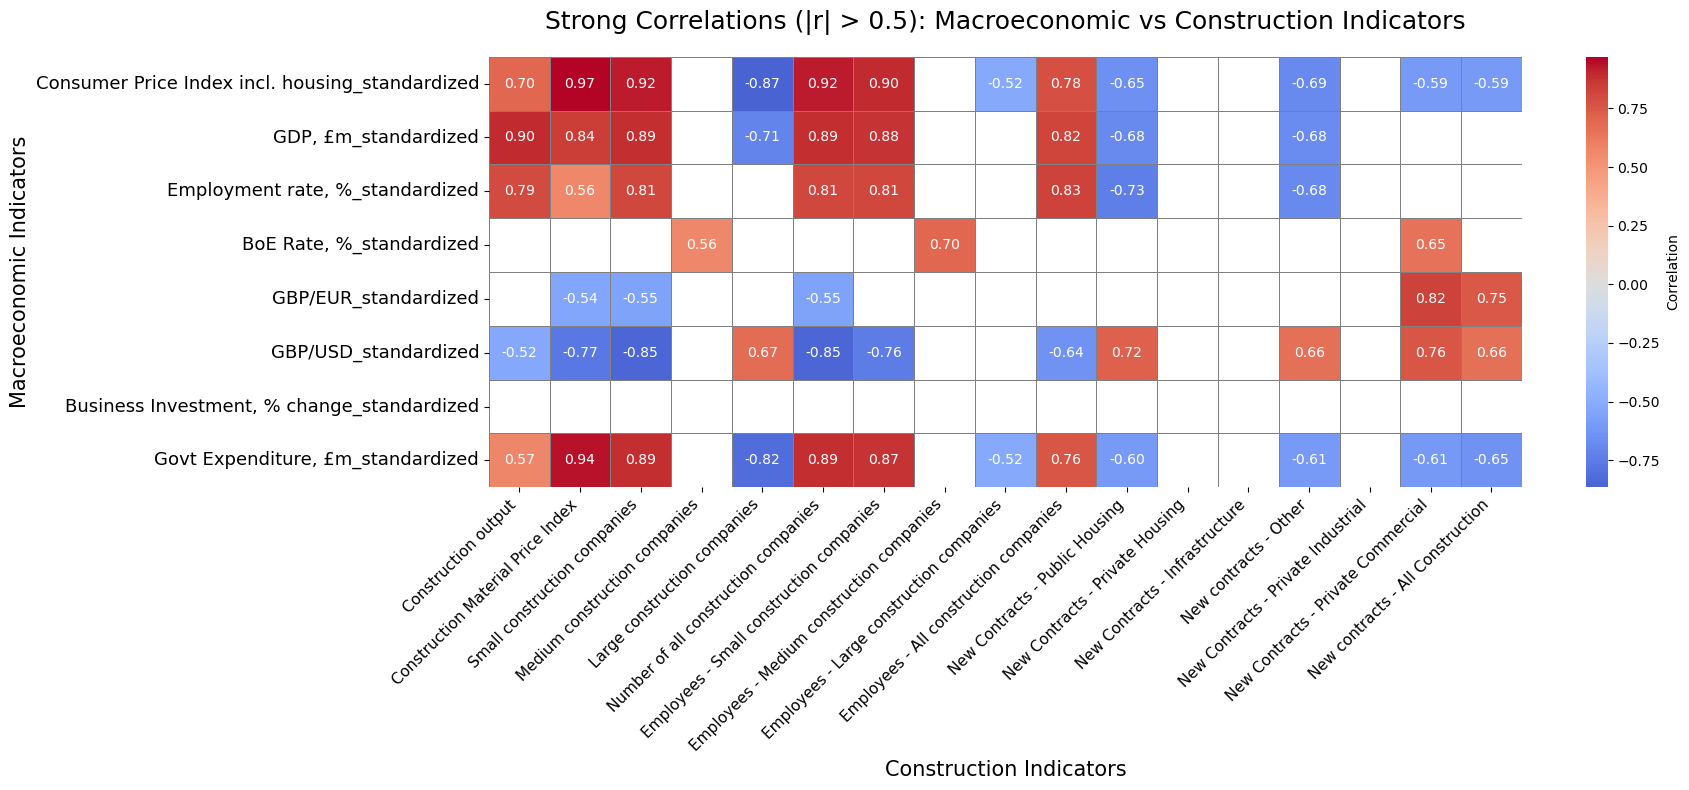

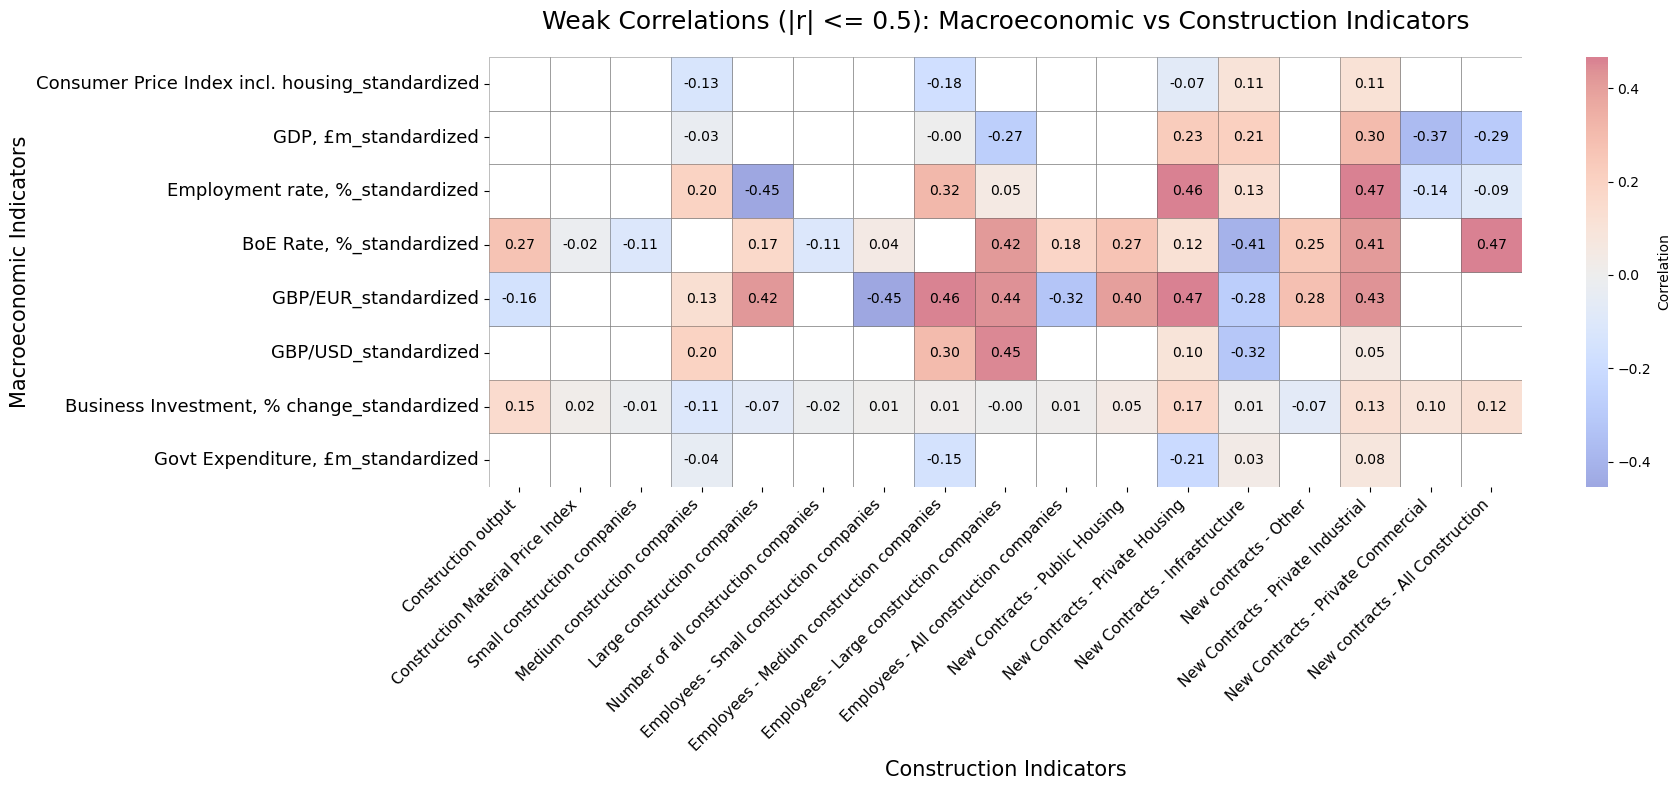

In [14]:
# Select the columns for the two groups
macro_cols = df_standardized.columns[:8]  # Macroeconomic indicators (8 columns)
construction_cols = df_standardized.columns[8:25]  # Construction indicators (17 columns)

# Calculate full 8x17 correlation matrix
correlation = pd.DataFrame(index=macro_cols, columns=construction_cols)

for macro in macro_cols:
    for constr in construction_cols:
        correlation.loc[macro, constr] = df_standardized[macro].corr(df_standardized[constr])

correlation = correlation.astype(float)

#Changing column and index names
correlation.columns = [
    name.split(',')[0] if ',' in name else name.split('_standardized')[0]
    for name in correlation.columns
]

# Filter: Keep only strong correlations (absolute value > 0.5), set others to NaN
filtered_strong_corr = correlation.where(correlation.abs() > 0.5)

# Filter: Keep only weak correlations (absolute value < 0.5), set others to NaN
mask = correlation.abs() >= 0.5

# Plot heatmap of strong correlations
plt.figure(figsize=(18, 8))
sns.heatmap(filtered_strong_corr, annot=True, fmt=".2f", cmap="coolwarm", center=0,
            cbar_kws={"label": "Correlation"}, linewidths=0.5, linecolor='gray')
plt.title("Strong Correlations (|r| > 0.5): Macroeconomic vs Construction Indicators", fontsize=18, pad=20)
plt.xlabel("Construction Indicators", fontsize=15)
plt.ylabel("Macroeconomic Indicators", fontsize=15)
plt.xticks(rotation=45, ha='right', fontsize=11)
plt.yticks(fontsize=13)
plt.tight_layout()
plt.show()

# Plot heatmap of weak correlations
plt.figure(figsize=(18, 8))
sns.heatmap(correlation, mask=mask, annot=True, annot_kws={"color": "black"}, fmt=".2f", cmap="coolwarm", alpha=0.5, center=0,
            cbar_kws={"label": "Correlation"}, linewidths=0.5, linecolor='gray')
plt.title("Weak Correlations (|r| <= 0.5): Macroeconomic vs Construction Indicators", fontsize=18, pad=20)
plt.xlabel("Construction Indicators", fontsize=15)
plt.ylabel("Macroeconomic Indicators", fontsize=15)
plt.xticks(rotation=45, ha='right', fontsize=11)
plt.yticks(fontsize=13)
plt.tight_layout()
plt.show()

### Correlation Insights Table

The following table summarizes key insights from the correlation heatmaps between macroeconomic indicators (CPIH, GDP, Employment rate, BoE Rate, GBP/EUR, GBP/USD, Business Investment, Government Expenditure) and construction sector indicators (2005–2025), highlighting relationships, implications, time-lag effects, and their relevance to the research questions.

| **Construction Indicator Category** | **Key Correlations** | **Insights and Implications** | **Potential Time-Lag Effects** | **Research Implications** |
| --- | --- | --- | --- | --- |
| **Construction Output** | GDP (0.90), Employment rate (0.79), CPIH (0.70), GBP/USD (-0.52) | Strong positive correlations with GDP and Employment rate confirm construction’s cyclical nature. Negative GBP/USD correlation suggests a stronger pound increases material costs, reducing output. | Lagged GDP effects (3–6 months) may amplify correlations, as economic growth drives construction with delays. | Test GDP and Employment rate as leading indicators for forecasting output using Granger causality. |
| **Construction Material Price Index** | CPIH (0.97), Govt Expenditure (0.94), GBP/USD (-0.77) | Near-perfect correlation with CPIH and strong link to Govt Expenditure show material prices track inflation and public spending. Negative GBP/USD correlation indicates imported material costs rise with a stronger pound. | Inflation lags (3–12 months) may strengthen price correlations, as material costs adjust gradually. | Use CPIH and Govt Expenditure in lagged regression to forecast material prices. |
| **Small Firms & Total Employees** | CPIH (0.78–0.92), GDP (0.82–0.89), Employment rate (0.81–0.83), GBP/USD (-0.64–0.85) | Small firms and total employment thrive during economic booms and high inflation, but a stronger pound reduces activity due to cost pressures. | Lagged economic growth (6–12 months) may enhance correlations, as small firms scale with demand. | Analyze small firms’ sensitivity to economic cycles for sub-sector forecasting. |
| **Medium & Large Firms/Employees** | CPIH (-0.13 to -0.87), GDP (-0.03 to -0.71), BoE Rate (0.42–0.70) | Weak/negative correlations with CPIH and GDP suggest larger firms face cost pressures or consolidation during economic growth. Unexpected positive BoE Rate correlation may reflect anticipatory investments. | Positive BoE Rate correlations may turn negative with lags (3–6 months) as borrowing costs impact larger firms. | Investigate divergent responses of medium/large firms using VAR models. |
| **New Contracts (Public Housing, Other, All)** | CPIH (-0.59 to -0.65), GDP (-0.29 to -0.68), Employment rate (-0.09 to -0.73) | Negative correlations indicate high economic growth or inflation delays new projects due to rising costs or capacity constraints. | Lagged GDP/CPIH effects (6–12 months) may reveal positive correlations as projects initiate post-cost stabilization. | Test impact of economic shocks (e.g., Brexit) on contract delays. |
| **New Contracts (Private Commercial)** | GBP/EUR (0.82), GBP/USD (0.76), BoE Rate (0.65) | Strong positive correlations with exchange rates and BoE Rate suggest commercial projects benefit from a stronger pound (foreign investment) and higher rates (anticipatory financing). | Lagged BoE Rate effects (3–6 months) may show negative correlations as borrowing costs deter projects. | Explore foreign investment’s role in commercial contracts using regression. |
| **New Contracts (Infrastructure, Private Industrial)** | CPIH (0.11), GDP (0.21–0.30), BoE Rate (-0.41 to 0.41) | Weak correlations suggest these sub-sectors are less sensitive to economic cycles, possibly due to long-term contracts or stable demand. | Minimal lag effects expected, but cross-correlation analysis can confirm if weak relationships strengthen over time. | Analyze infrastructure’s stability for robust forecasting models. |


The correlation heatmaps reveals strong ties between construction output, small firms, and macroeconomic indicators (GDP, CPIH, Employment rate), confirming the sector’s cyclical nature. Material prices track inflation and public spending. Medium and large firms and new contracts show unexpected patterns, probably due to time lags (3–12 months). These insights directly address research questions on correlations, predictive modeling, time lags, sub-sector impacts, and black swan events.

### Authors

[Alisa Makhonina](https://www.linkedin.com/in/alisa-makhonina-data-science/) Data scientist with over 8 years of experience in construction cost engineering. Structural Engineering graduate.